In [ ]:
# default_exp data

# Data

> Visualize the dataset.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev import show_doc

In [ ]:
# export
from steel_segmentation.core import *
from fastcore.foundation import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## An example

From an `ImageId` we get the pixel coordinates or the mask for every defect. Here an example of steel image.

            ImageId  ClassId
6757  f383950e8.jpg        3
6758  f383950e8.jpg        4


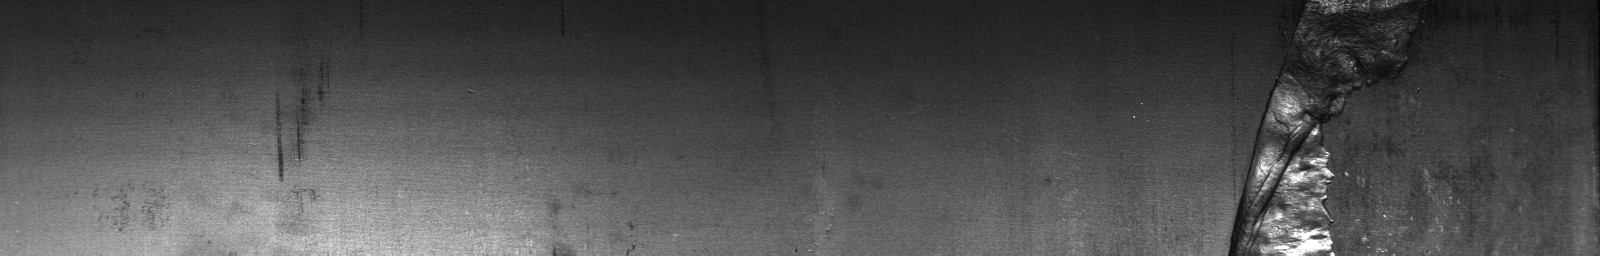

In [ ]:
img_id = "f383950e8.jpg"
tmp_df = train[train['ImageId'] == img_id]
img_path = train_path / img_id
im = Image.open(img_path)

print(tmp_df[["ImageId", "ClassId"]])
im

In [ ]:
height, width = im.shape
height, width

(256, 1600)

In [ ]:
assert height == 256
assert width == 1600

## Discovery defect functions

In [ ]:
# export
def defeat_position(img_id: str, class_id: int, df: pd.DataFrame = train):
    """
    Get coordinates of defects `(x, y)` given an ImageId and a ClassId 
    """
    # Select the image to mask
    # cond = df.ImageId_ClassId == f"{img_id}_{class_id}"
    cond = (df.ImageId == img_id) & (df.ClassId == class_id)
    train_s = df[cond]

    encoded_pixels = [int(i)
                      for i in train_s.EncodedPixels.values[0].split(" ")]

    pixcels = []
    pos_pixels = encoded_pixels[0:len(encoded_pixels):2]
    offs_pixels = encoded_pixels[1:len(encoded_pixels):2]

    for pos, offset in zip(pos_pixels, offs_pixels):
        pixcels.extend(list(range(pos, pos+offset)))

    pixcels = np.array(pixcels)
    x = pixcels // 256
    y = pixcels % 256

    return x, y

In [ ]:
x, y = defeat_position(img_id=img_id, class_id=4)
x.shape, y.shape

((36002,), (36002,))

## Picking functions

In [ ]:
# export
def get_random_idx(n: int) -> np.ndarray:
    """
    Return a random sequence of size `n`.
    """
    rng = np.random.default_rng()
    return rng.permutation(n)

In [ ]:
get_random_idx(50)

array([25, 16, 11, 13, 48, 23,  1,  0, 29, 27,  5, 35, 17,  6, 36, 34, 26,
        3,  7, 33, 22, 20, 42, 38, 41, 18, 14, 10, 30, 28, 19, 32, 40, 47,
       24, 45, 39, 44, 46, 21,  2, 49, 43,  8,  9, 31, 12, 37,  4, 15])

In [ ]:
# export
def get_perm_imgs_path(train_pfiles: L, df: pd.DataFrame) -> L:
    """
    Return img Path list of selected df.
    """
    imgId_vals = df["ImageId"].drop_duplicates().values
    path_idx = train_pfiles.argwhere(lambda x: x.name in imgId_vals)
    sel_paths = train_pfiles[path_idx]
    idx = get_random_idx(len(sel_paths))
    return sel_paths[idx]

In [ ]:
get_perm_imgs_path(train_pfiles, train_all)[:5]

(#5) [Path('../data/train_images/5b53fc5e8.jpg'),Path('../data/train_images/19e9bfbf2.jpg'),Path('../data/train_images/47f5c8e07.jpg'),Path('../data/train_images/0803acf1f.jpg'),Path('../data/train_images/bf96d0602.jpg')]

## Show defects

In [ ]:
# export
def plot_defected_image(img_path: str, df: pd.DataFrame = train):
    """
    Plot image with segmented area
    """
    def color(x, y, classid):
        if classid == 4:
            im[y, x, 1] += 50
            im[y, x, 2] += 50
        else:
            im[y, x, classid-1] += 50

    def plot(im, imgid, classids):
        clip_im = np.clip(im, 0, 255)
        title = "ImageId: {} - ClassId: {}".format(
            imgid, " ".join(map(str, classids)))

        plt.figure(figsize=(25, 5))
        plt.imshow(clip_im)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=20)
        plt.show()

    im = np.array(Image.open(img_path))

    img_id = img_path.name
    df = df.loc[df["ImageId"] == img_id]

    classids = []
    for img in df.itertuples(index=False):
        classids.append(img.ClassId)
        classid = img.ClassId

        x, y = defeat_position(img_id, classid)

        color(x, y, classid)

    plot(im, img_id, classids)

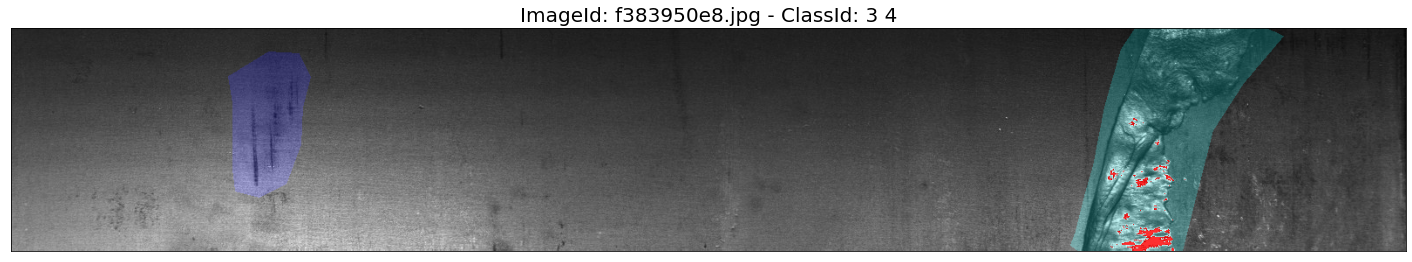

In [ ]:
plot_defected_image(img_path)

In [ ]:
# export
def show_defects(class_id=None, n=20, only_defects=True, multi_defects=False):
    """
    Plot multiple images. 
    Attributes: 
    `class_id`: [str or int] select a type of defect otherwise plot all kinds;
    `n`: select the number of images to plot;
    `only_defects` [bool, default True]: if False it shows even the no faulty images;
    `multi_defects` [bool, default False]: if True it shows imgs with multi defects.
    """
    df = train_multi

    cond_no_defects = df["ClassId_multi"] == '0'
    cond_multi_defects = df["ClassId_multi"].map(lambda x: len(x) > 1)
    cond_classId = df["ClassId_multi"].map(lambda x: str(class_id) in x)

    df = df.loc[cond_no_defects] if not only_defects else df.loc[~cond_no_defects]
    df = df.loc[cond_multi_defects] if multi_defects else df.loc[~cond_multi_defects]
    df = df.loc[cond_classId] if class_id else df

    imgid_from_df = df["ImageId"].tolist()
    pfiles_list = L([train_path / imgid for imgid in imgid_from_df])

    perm_paths = get_perm_imgs_path(pfiles_list, df)
    for img_path in perm_paths[:n]:
        plot_defected_image(img_path)

The `ClassId = 1` identifies single and multiple defects in the form of rounded spots.

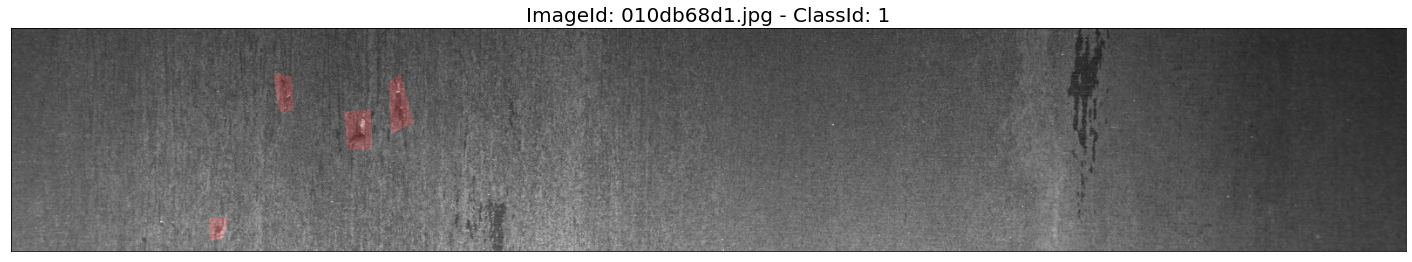

In [ ]:
show_defects(class_id=1, n=1)

The `ClassId = 2` identifies single and multiple defects of grooves.

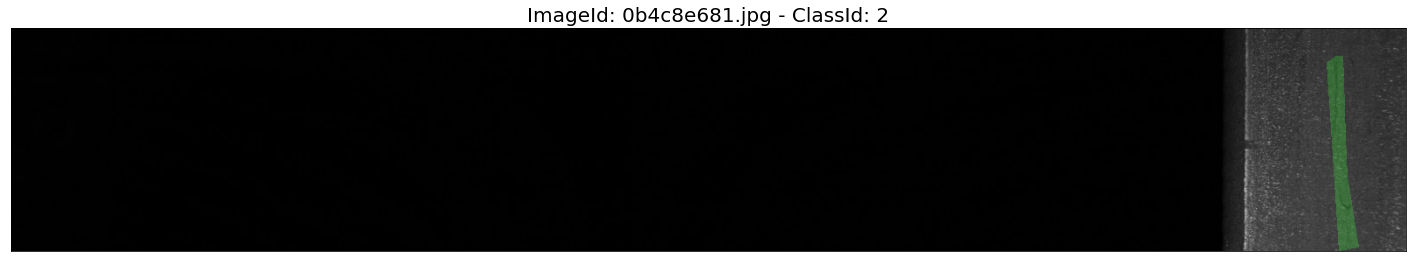

In [ ]:
show_defects(class_id=2, n=1)

The `ClassId = 3` identifies single and multiple defects of scratches.

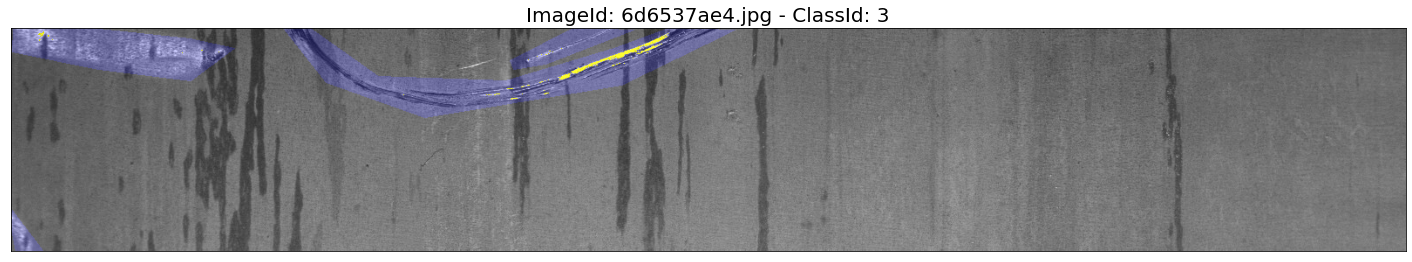

In [ ]:
show_defects(class_id=3, n=1)

The `ClassId = 4` identifies single and multiple defects of rolling process.

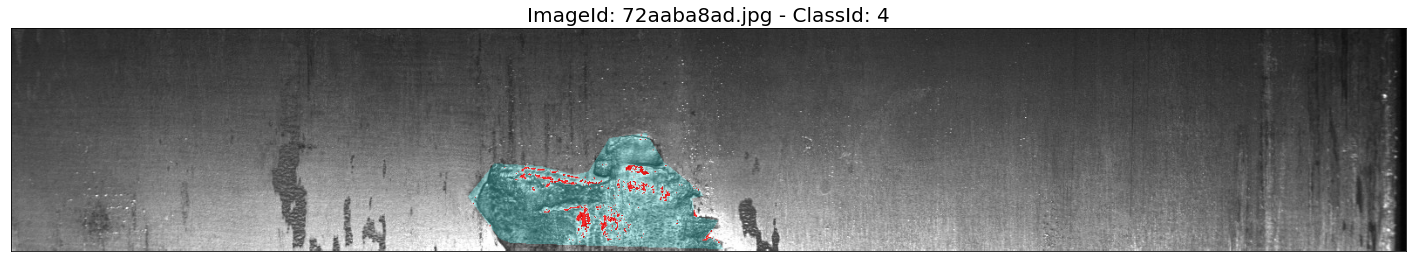

In [ ]:
show_defects(class_id=4, n=1)

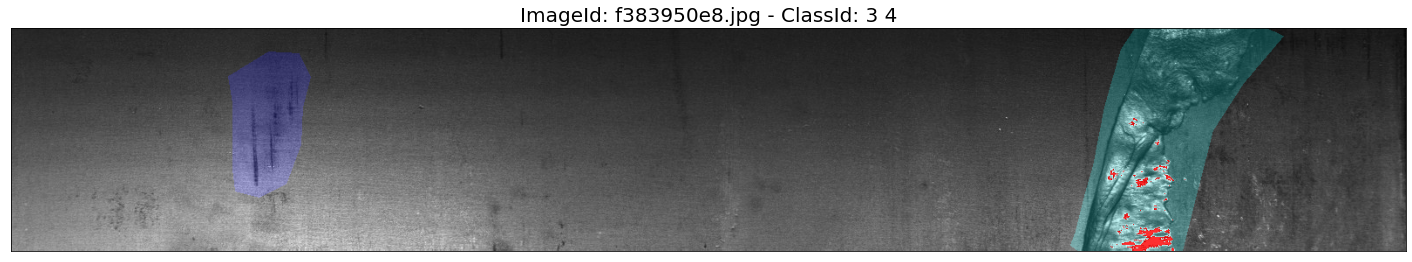

In [ ]:
show_defects(n=1, multi_defects=True)

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_models.dls.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted index.ipynb.
